# Script to plot average causal effects

This script loads sets of hundreds of causal traces that have been computed by the
`experiment.causal_trace` program, and then aggregates the results to compute
Average Indirect Effects and Average Total Effects as well as some other information.


Average Total Effect 0.22891893134426972
Best average indirect effect on last subject 0.09501422093224425
Best average indirect effect on last token 0.22891925916981598
Average best-fixed score 0.28544617
Average best-fixed on last subject token score 0.15923415
Average best-fixed on last word score 0.27898633
Argmax at last subject token 13
Max at last subject token 0.13375108
Argmax at last prompt token 47
Max at last prompt token 0.26765612


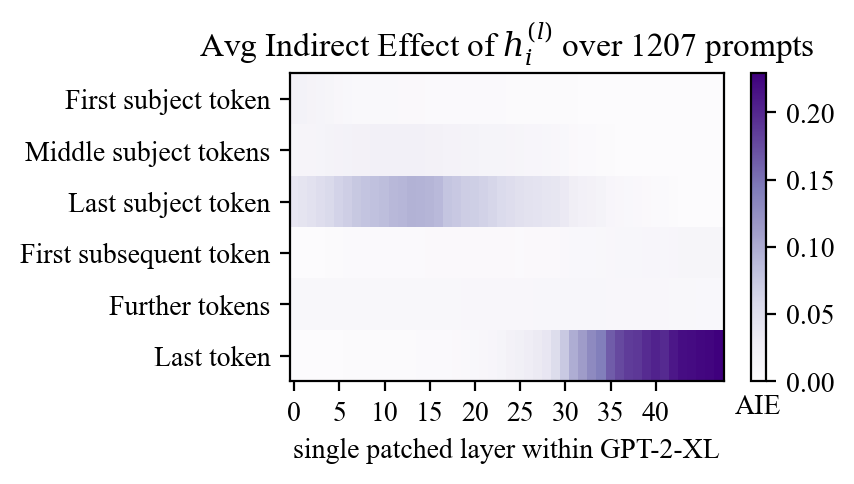

Average Total Effect 0.22891893134426972
Best average indirect effect on last subject 0.056572354295968005
Best average indirect effect on last token 0.025629057446240375
Average best-fixed score 0.17684174
Average best-fixed on last subject token score 0.14088467
Average best-fixed on last word score 0.07152176
Argmax at last subject token 17
Max at last subject token 0.09530921
Argmax at last prompt token 35
Max at last prompt token 0.064365916


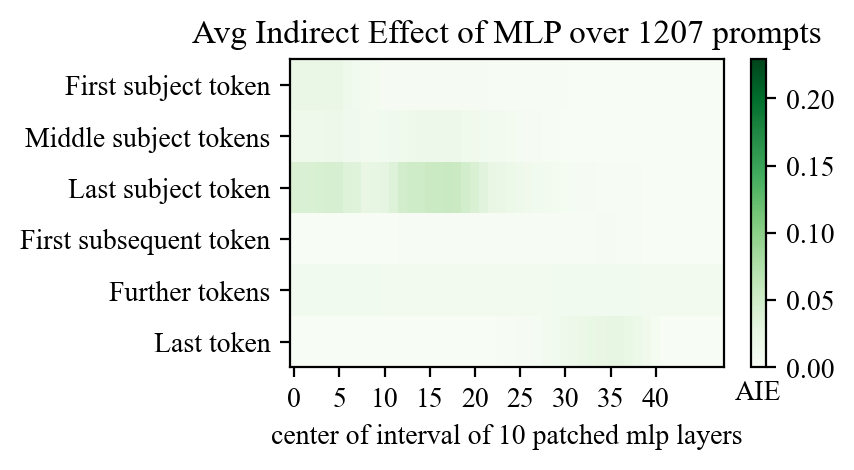

Average Total Effect 0.22891893134426972
Best average indirect effect on last subject 0.013922295430420825
Best average indirect effect on last token 0.08568052844118972
Average best-fixed score 0.14854701
Average best-fixed on last subject token score 0.06881406
Average best-fixed on last word score 0.14255577
Argmax at last subject token 0
Max at last subject token 0.052659154
Argmax at last prompt token 31
Max at last prompt token 0.12441739


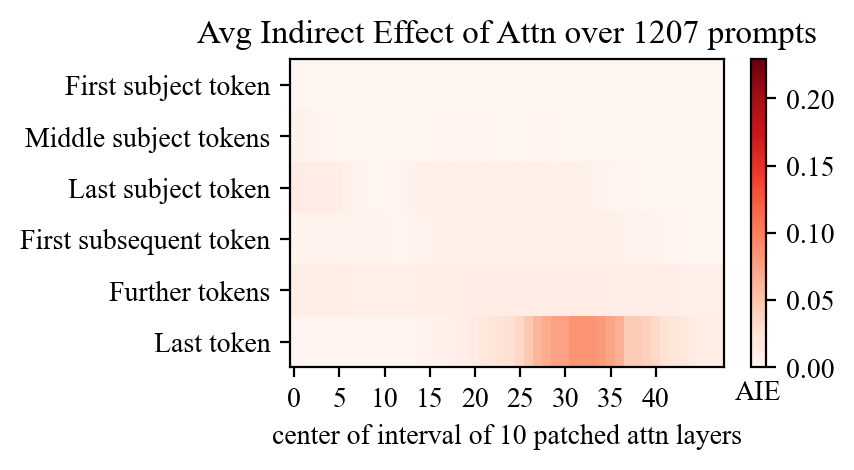

In [7]:
import numpy, os
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Uncomment the architecture to plot.
arch = "ns3_r0_gpt2-xl"
archname = "GPT-2-XL"

# arch = 'EleutherAI_gpt-j-6B'
# archname = 'GPT-J-6B'

# arch = 'EleutherAI_gpt-neox-20b'
# archname = 'GPT-NeoX-20B'


class Avg:
    def __init__(self):
        self.d = []

    def add(self, v):
        self.d.append(v[None])

    def add_all(self, vv):
        self.d.append(vv)

    def avg(self):
        return numpy.concatenate(self.d).mean(axis=0)

    def std(self):
        return numpy.concatenate(self.d).std(axis=0)

    def size(self):
        return sum(datum.shape[0] for datum in self.d)


def read_knowlege(count=150, kind=None, arch="gpt2-xl"):
    dirname = "/home/rameshbabu/rome-main/results/ns3_r0_gpt2-xl/causal_trace/cases"
    kindcode = "" if not kind else f"_{kind}"
    (
        avg_fe,
        avg_ee,
        avg_le,
        avg_fa,
        avg_ea,
        avg_la,
        avg_hs,
        avg_ls,
        avg_fs,
        avg_fle,
        avg_fla,
    ) = [Avg() for _ in range(11)]
    for i in range(count):
        try:
            data = numpy.load(f"{dirname}/knowledge_{i}{kindcode}.npz")
        except:
            continue
        # Only consider cases where the model begins with the correct prediction
        if "correct_prediction" in data and not data["correct_prediction"]:
            continue
        scores = data["scores"]
        first_e, first_a = data["subject_range"]
        last_e = first_a - 1
        last_a = len(scores) - 1
        # original prediction
        avg_hs.add(data["high_score"])
        # prediction after subject is corrupted
        avg_ls.add(data["low_score"])
        avg_fs.add(scores.max())
        # some maximum computations
        avg_fle.add(scores[last_e].max())
        avg_fla.add(scores[last_a].max())
        # First subject middle, last subjet.
        avg_fe.add(scores[first_e])
        avg_ee.add_all(scores[first_e + 1 : last_e])
        avg_le.add(scores[last_e])
        # First after, middle after, last after
        avg_fa.add(scores[first_a])
        avg_ea.add_all(scores[first_a + 1 : last_a])
        avg_la.add(scores[last_a])

    result = numpy.stack(
        [
            avg_fe.avg(),
            avg_ee.avg(),
            avg_le.avg(),
            avg_fa.avg(),
            avg_ea.avg(),
            avg_la.avg(),
        ]
    )
    result_std = numpy.stack(
        [
            avg_fe.std(),
            avg_ee.std(),
            avg_le.std(),
            avg_fa.std(),
            avg_ea.std(),
            avg_la.std(),
        ]
    )
    print("Average Total Effect", avg_hs.avg() - avg_ls.avg())
    print(
        "Best average indirect effect on last subject",
        avg_le.avg().max() - avg_ls.avg(),
    )
    print(
        "Best average indirect effect on last token", avg_la.avg().max() - avg_ls.avg()
    )
    print("Average best-fixed score", avg_fs.avg())
    print("Average best-fixed on last subject token score", avg_fle.avg())
    print("Average best-fixed on last word score", avg_fla.avg())
    print("Argmax at last subject token", numpy.argmax(avg_le.avg()))
    print("Max at last subject token", numpy.max(avg_le.avg()))
    print("Argmax at last prompt token", numpy.argmax(avg_la.avg()))
    print("Max at last prompt token", numpy.max(avg_la.avg()))
    return dict(
        low_score=avg_ls.avg(), result=result, result_std=result_std, size=avg_fe.size()
    )


def plot_array(
    differences,
    kind=None,
    savepdf=None,
    title=None,
    low_score=None,
    high_score=None,
    archname="GPT2-XL",
):
    if low_score is None:
        low_score = differences.min()
    if high_score is None:
        high_score = differences.max()
    answer = "AIE"
    labels = [
        "First subject token",
        "Middle subject tokens",
        "Last subject token",
        "First subsequent token",
        "Further tokens",
        "Last token",
    ]

    fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
    h = ax.pcolor(
        differences,
        cmap={None: "Purples", "mlp": "Greens", "attn": "Reds"}[kind],
        vmin=low_score,
        vmax=high_score,
    )
    if title:
        ax.set_title(title)
    ax.invert_yaxis()
    ax.set_yticks([0.5 + i for i in range(len(differences))])
    ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
    ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
    ax.set_yticklabels(labels)
    if kind is None:
        ax.set_xlabel(f"single patched layer within {archname}")
    else:
        ax.set_xlabel(f"center of interval of 10 patched {kind} layers")
    cb = plt.colorbar(h)
    # The following should be cb.ax.set_xlabel(answer), but this is broken in matplotlib 3.5.1.
    if answer:
        cb.ax.set_title(str(answer).strip(), y=-0.16, fontsize=10)

    if savepdf:
        os.makedirs(os.path.dirname(savepdf), exist_ok=True)
        plt.savefig(savepdf, bbox_inches="tight")
    plt.show()


the_count = 1208
high_score = None  # Scale all plots according to the y axis of the first plot

for kind in [None, "mlp", "attn"]:
    d = read_knowlege(the_count, kind, arch)
    count = d["size"]
    what = {
        None: "Indirect Effect of $h_i^{(l)}$",
        "mlp": "Indirect Effect of MLP",
        "attn": "Indirect Effect of Attn",
    }[kind]
    title = f"Avg {what} over {count} prompts"
    result = numpy.clip(d["result"] - d["low_score"], 0, None)
    kindcode = "" if kind is None else f"_{kind}"
    if kind not in ["mlp", "attn"]:
        high_score = result.max()
    plot_array(
        result,
        kind=kind,
        title=title,
        low_score=0.0,
        high_score=high_score,
        archname=archname,
        savepdf=f"results/{arch}/causal_trace/summary_pdfs/rollup{kindcode}.pdf",
    )

## Plot line graph

To make confidence intervals visible, we plot the data as line graphs below.

Reading None
Average Total Effect 0.25161574734952713
Best average indirect effect on last subject 0.10792832030561234
Best average indirect effect on last token 0.25161568774488235
Average best-fixed score 0.30787775
Average best-fixed on last subject token score 0.17237915
Average best-fixed on last word score 0.30150032
Argmax at last subject token 13
Max at last subject token 0.14516708
Argmax at last prompt token 47
Max at last prompt token 0.28885445
Reading mlp
Average Total Effect 0.25161574734952713
Best average indirect effect on last subject 0.0650625969341066
Best average indirect effect on last token 0.028006076352861176
Average best-fixed score 0.18690482
Average best-fixed on last subject token score 0.1550765
Average best-fixed on last word score 0.07292962
Argmax at last subject token 16
Max at last subject token 0.10230136
Argmax at last prompt token 35
Max at last prompt token 0.06524484
Reading attn
Average Total Effect 0.25161574734952713
Best average indirect effe

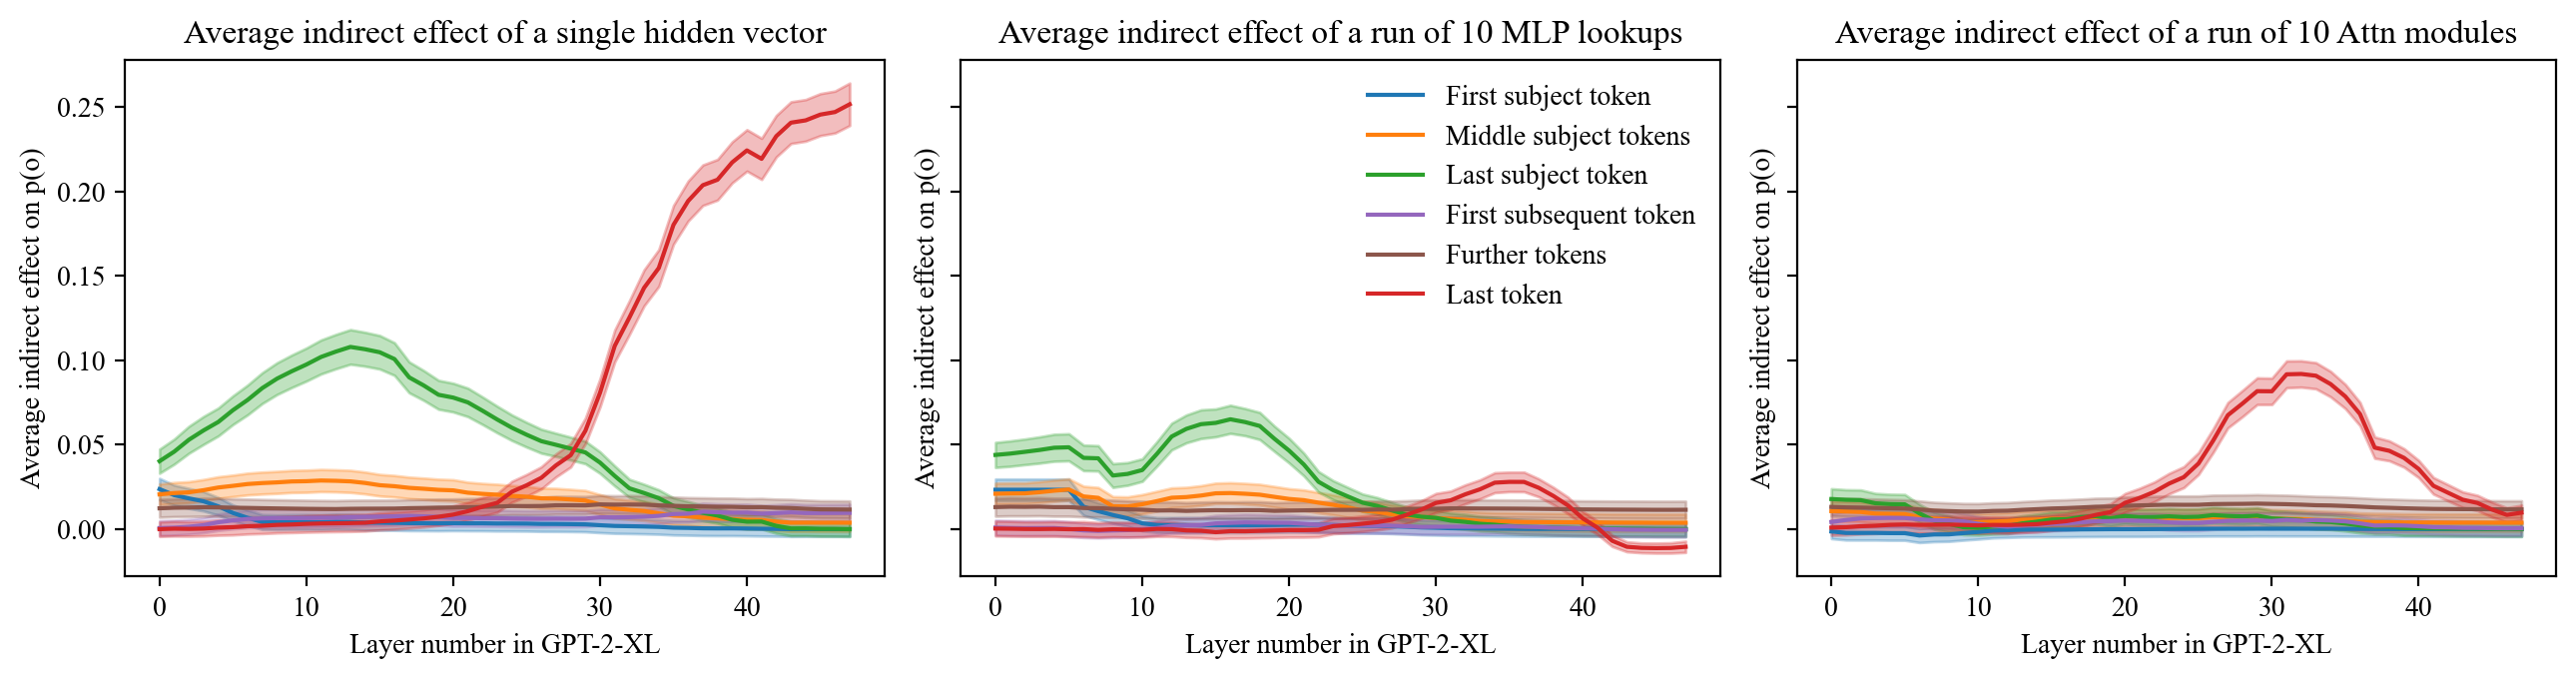

In [3]:
import math

labels = [
    "First subject token",
    "Middle subject tokens",
    "Last subject token",
    "First subsequent token",
    "Further tokens",
    "Last token",
]
color_order = [0, 1, 2, 4, 5, 3]
x = None

cmap = plt.get_cmap("tab10")
fig, axes = plt.subplots(1, 3, figsize=(13, 3.5), sharey=True, dpi=200)
for j, (kind, title) in enumerate(
    [
        (None, "single hidden vector"),
        ("mlp", "run of 10 MLP lookups"),
        ("attn", "run of 10 Attn modules"),
    ]
):
    print(f"Reading {kind}")
    d = read_knowlege(225, kind, arch)
    for i, label in list(enumerate(labels)):
        y = d["result"][i] - d["low_score"]
        if x is None:
            x = list(range(len(y)))
        std = d["result_std"][i]
        error = std * 1.96 / math.sqrt(count)
        axes[j].fill_between(
            x, y - error, y + error, alpha=0.3, color=cmap.colors[color_order[i]]
        )
        axes[j].plot(x, y, label=label, color=cmap.colors[color_order[i]])

    axes[j].set_title(f"Average indirect effect of a {title}")
    axes[j].set_ylabel("Average indirect effect on p(o)")
    axes[j].set_xlabel(f"Layer number in {archname}")
    # axes[j].set_ylim(0.1, 0.3)
axes[1].legend(frameon=False)
plt.tight_layout()
plt.savefig(f"results/{arch}/causal_trace/summary_pdfs/lineplot-causaltrace.pdf")
plt.show()